In [1]:
#imports
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
#reading the csv file
dir  = globals()['_dh'][0].parent
file_path = dir / 'data' / 'cleaned_data.pkl'
df = pd.read_pickle(file_path)
print(df.shape)
df.head(5)


(16680, 16)


,OrgID,EnrollDate,ChurnDate,OrgSize,Industry,IndustryGroup,Enrollment Plan,PromoType,Acquisition Channel,F28 Active Rate,Avg Lifetime Active,F28 Cc Flag,eLTV/CAC,Churned,Enrollment Duration,User_id
0,44,2021-02-01,NaT,0-1,Flooring,Other,Extra large,No Promo,Marketing - Paid,0.607,0.096,0,4.1,0,676.0,4420210201
1,70,2022-03-01,NaT,0-1,Plumbing,Plumbing,Starter,No Promo,NaN,0.071,0.340,0,1.2,0,283.0,7020220301
2,1494,2020-10-02,NaT,0-1,Carpet Cleaning,Carpet Cleaning,Small,No Promo,Product,1.000,0.379,1,3.4,0,798.0,149420201002
3,1604,2020-10-08,2020-12-08,11+,Restoration,Other,Large,2+ month,Sales,0.500,0.004,0,6.2,1,61.0,160420201008
4,1652,2020-02-03,2020-03-02,11+,Solar & Energy,Other,Large,One Month,Sales,0.000,0.001,0,4.7,1,28.0,165220200203


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16680 entries, 0 to 16679
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   OrgID                16680 non-null  int64         
 1   EnrollDate           16680 non-null  datetime64[ns]
 2   ChurnDate            6703 non-null   datetime64[ns]
 3   OrgSize              16671 non-null  category      
 4   Industry             16655 non-null  object        
 5   IndustryGroup        16680 non-null  object        
 6   Enrollment Plan      16677 non-null  category      
 7   PromoType            16680 non-null  category      
 8   Acquisition Channel  15947 non-null  object        
 9   F28 Active Rate      16680 non-null  float64       
 10  Avg Lifetime Active  16680 non-null  float64       
 11  F28 Cc Flag          16680 non-null  int64         
 12  eLTV/CAC             16549 non-null  float64       
 13  Churned              16680 non-

## 1 - Analysing from Enroll Plan
Findings: \
2 - large plans have a lower share of churn in proportion to its user base. \
3 - Medium plans are insighnificant, is it a strategy or this plan need to be remodeled? \
4 - 2+ month and special promos work best for large and extra large plans \
5 - The greater the plan, the greater the ltv/cac ratio \
6 - Larger organization prefers better plans \
7 - There is a niche of 2-6 orgsize organizations that prefer larger plans, specially for Heating & Air Conditioning and Plumbing \



In [4]:
#percentual of churned users
churn_perc = df[df['ChurnDate'].notnull()]['ChurnDate'].count() / len(df) * 100
churn_perc

40.18585131894484

In [5]:
#drop rows with freeze from Enrollment Plan 
df.drop(df[df['Enrollment Plan'] == 'Freeze'].index, inplace=True)

In [6]:
#percentual of users for each promo type
df_promo = pd.DataFrame()
df_promo['users'] = df.groupby('Enrollment Plan')['Enrollment Plan'].count()
df_promo['users_perc'] = df.groupby('Enrollment Plan')['Enrollment Plan'].count() / len(df)

#percentual of churned users for each promo type 
df_promo['churned_users'] = df[df['ChurnDate'].notnull()].groupby('Enrollment Plan')['Enrollment Plan'].count()
df_promo['churned_users_perc'] = (df_promo['churned_users'] / df_promo['users'])

#share of churned users regarding all churned users for each promo type
df_promo['share_of_churned_users'] = df_promo['churned_users'] / df[df['ChurnDate'].notnull()]['ChurnDate'].count()

#average duration of enrollment for each promo type
df_promo['avg_duration'] = df.groupby('Enrollment Plan')['Enrollment Duration'].mean()

#average F28 Active Rate for each promo type
df_promo['avg_F28_Active_Rate'] = df.groupby('Enrollment Plan')['F28 Active Rate'].mean()

#average Avg Lifetime Active for each promo type
df_promo['avg_Avg_Lifetime_Active'] = df.groupby('Enrollment Plan')['Avg Lifetime Active'].mean()

#avg ltv/cac for each promo type
df_promo['avg_ltv_cac'] = df.groupby('Enrollment Plan')['eLTV/CAC'].mean()

#avg financial impact for each promo type
df_promo['avg_financial_impact'] = (df_promo['users'] - df_promo['churned_users']) * df_promo['avg_ltv_cac']

#most predominant PromoType for each promo type -----------------------
df_promo['most_predominant_PromoType'] = df.groupby('Enrollment Plan')['PromoType'].agg(lambda x:x.value_counts().index[0])

#most predominant Enrollment Planfor each promo type
df_promo['most_predominant_Enrollment_Plan'] = df.groupby('Enrollment Plan')['OrgSize'].agg(lambda x:x.value_counts().index[0])

#most predominant Industry for each promo type
#df_promo['most_predominant_Industry'] = df.groupby('Enrollment Plan')['Industry'].agg(lambda x:x.value_counts().index[0])

#most predominant Industry Group for each promo type
#df_promo['most_predominant_Industry_Group'] = df.groupby('Enrollment Plan')['IndustryGroup'].agg(lambda x:x.value_counts().index[0])

#most_predominant Acquisition Channel for each promo type
#df_promo['most_predominant_Acquisition_Channel'] = df.groupby('Enrollment Plan')['Acquisition Channel'].agg(lambda x:x.value_counts().index[0])

df_promo.head()


,users,users_perc,churned_users,churned_users_perc,share_of_churned_users,avg_duration,avg_F28_Active_Rate,avg_Avg_Lifetime_Active,avg_ltv_cac,avg_financial_impact,most_predominant_PromoType,most_predominant_Enrollment_Plan
Enrollment Plan,,,,,,,,,,,,
Starter,3351,0.200899,1117,0.333333,0.166642,390.522232,0.253230,0.199944,0.935335,2089.537796,One Month,0-1
Small,10010,0.600120,4578,0.457343,0.682978,348.769031,0.274698,0.229783,2.329884,12655.931233,One Month,2-6
Medium,17,0.001019,10,0.588235,0.001492,351.235294,0.197471,0.242647,4.423529,30.964706,One Month,7-10
Large,2651,0.158933,759,0.286307,0.113233,421.492267,0.345837,0.351716,7.877129,14903.527453,Special - One Month,2-6
Extra large,648,0.038849,238,0.367284,0.035506,380.391975,0.317517,0.330829,13.136646,5386.024845,2+ month,11+


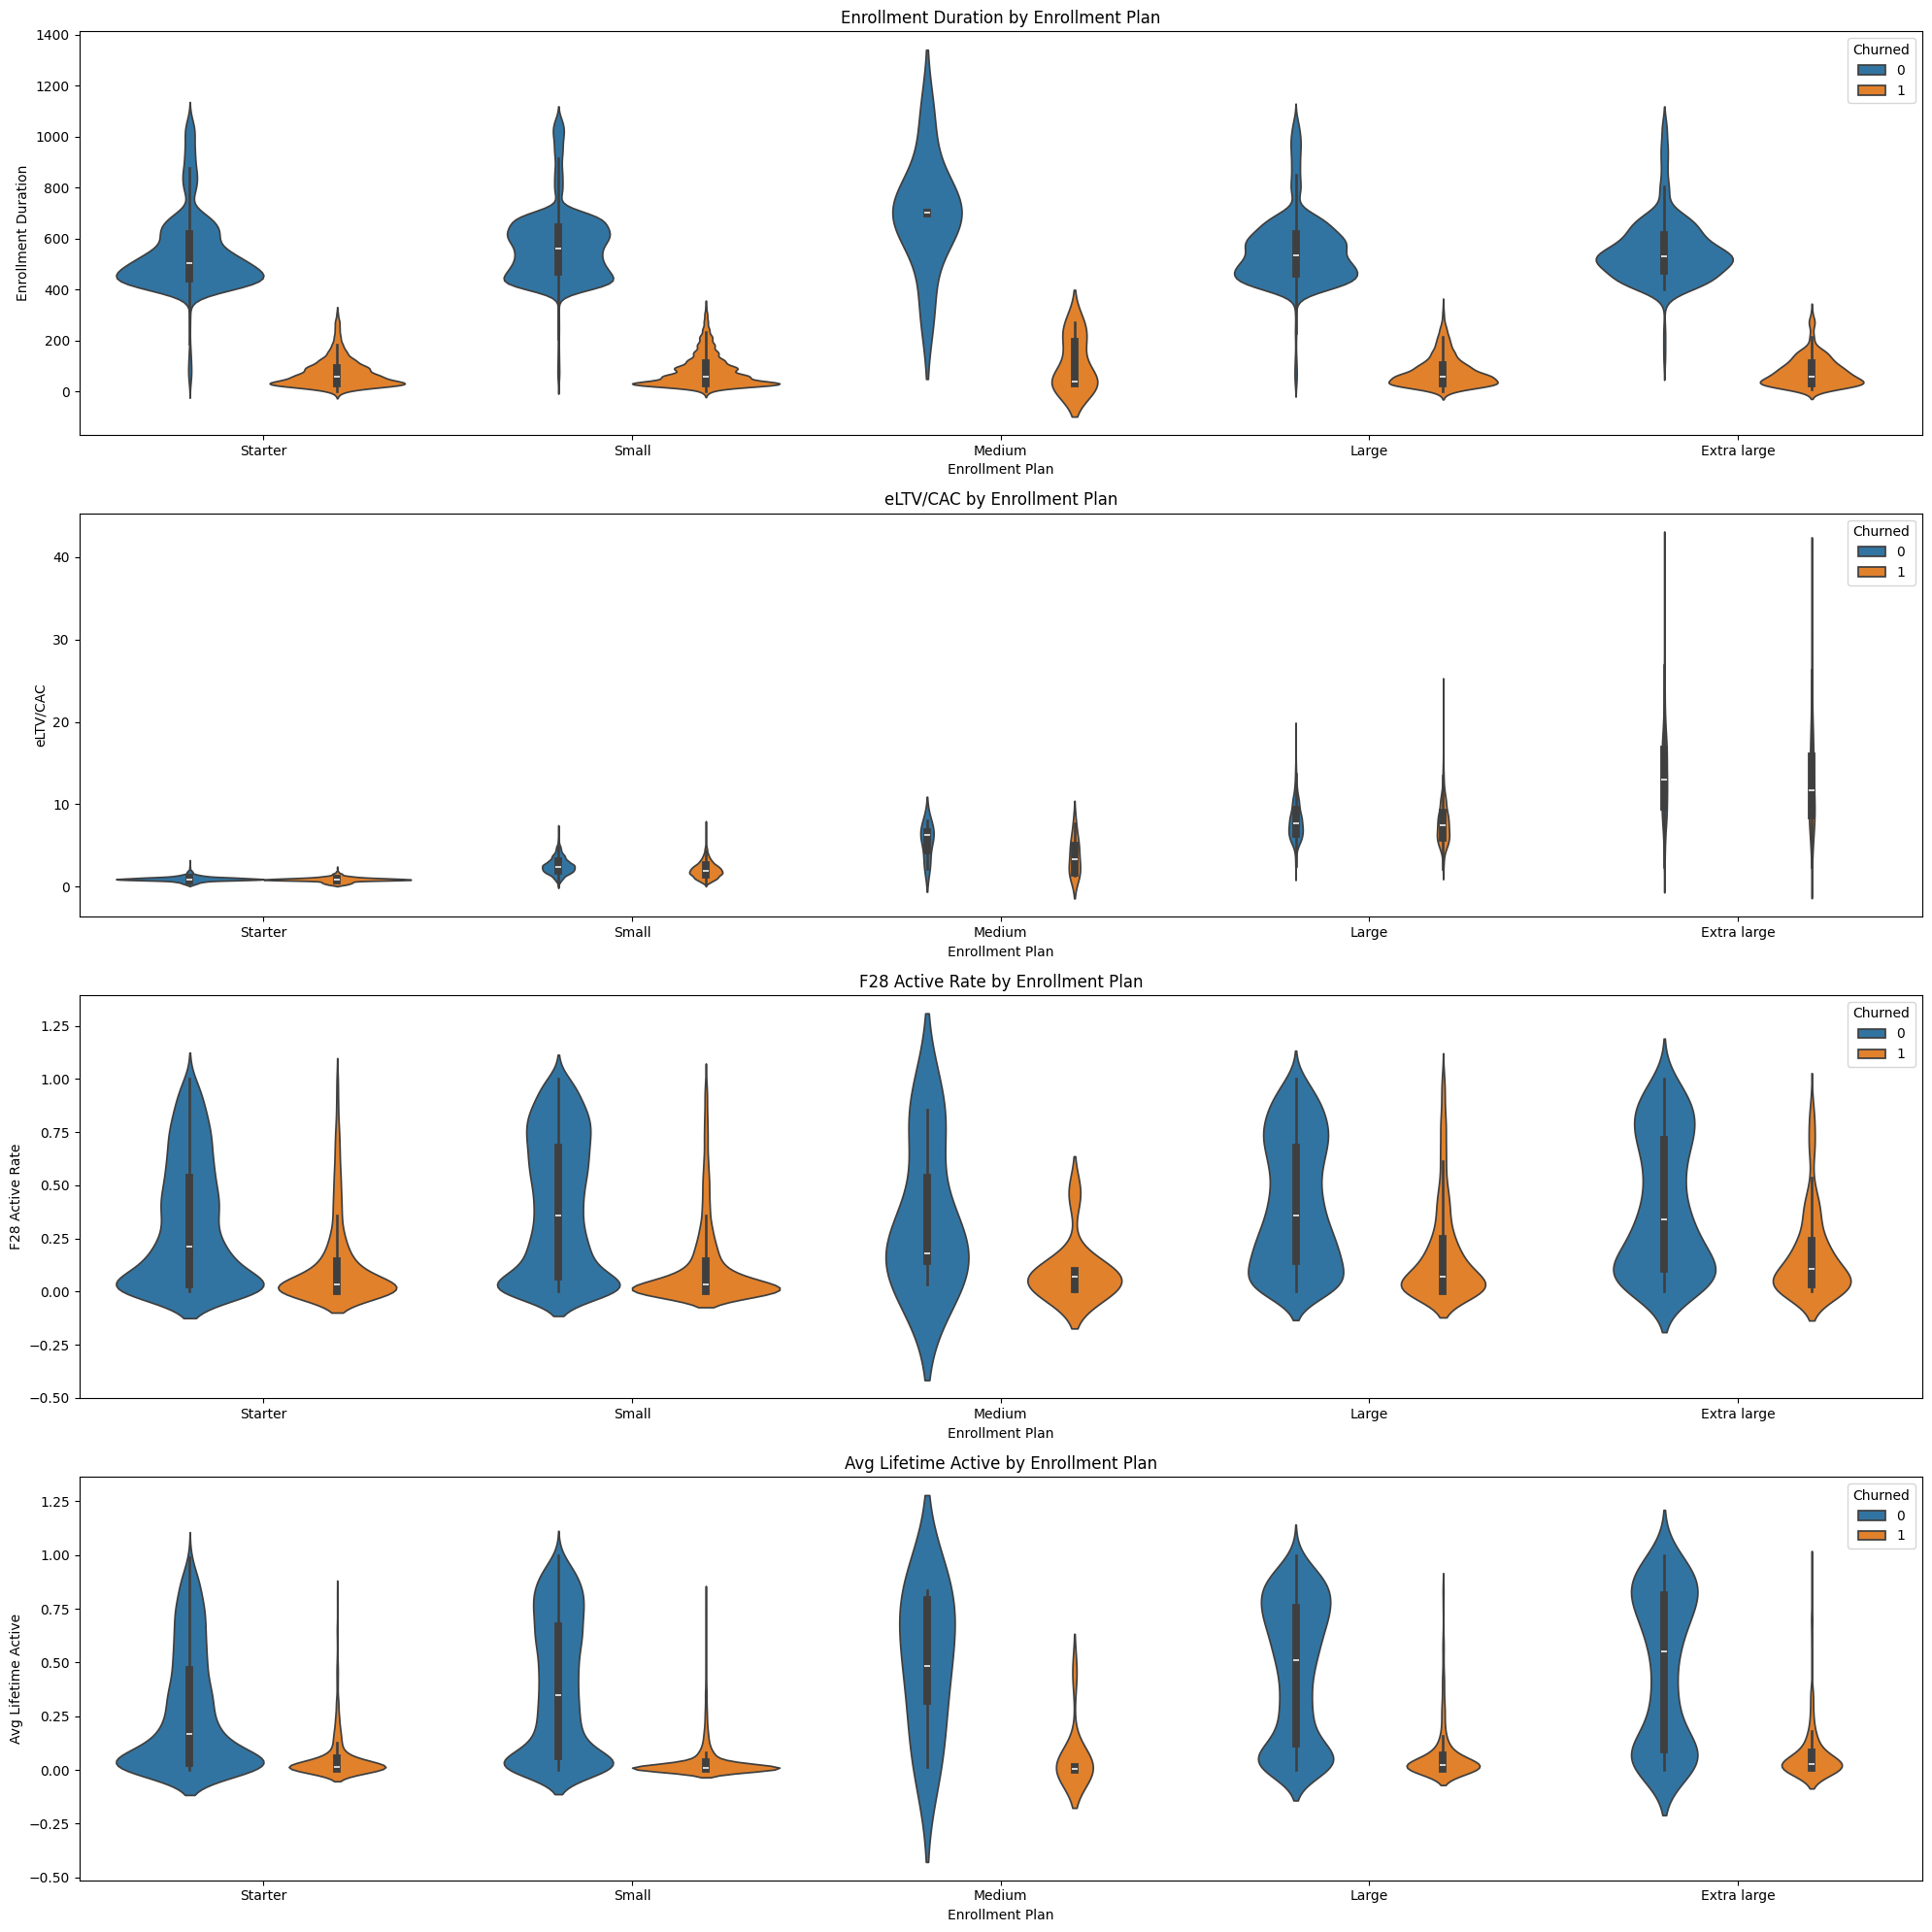

In [7]:
#violin plot for the promotion type
fig, axs = plt.subplots(4,1, figsize=(20, 20))

sns.violinplot(x='Enrollment Plan', y='Enrollment Duration', data=df, ax=axs[0], hue="Churned")
axs[0].set_title('Enrollment Duration by Enrollment Plan')  # Set title for the first subplot

sns.violinplot(x='Enrollment Plan', y='eLTV/CAC', data=df, ax=axs[1], hue="Churned")
axs[1].set_title('eLTV/CAC by Enrollment Plan')  # Set title for the second subplot

sns.violinplot(x='Enrollment Plan', y='F28 Active Rate', data=df, ax=axs[2], hue="Churned")
axs[2].set_title('F28 Active Rate by Enrollment Plan')  # Set title for the third subplot

sns.violinplot(x='Enrollment Plan', y='Avg Lifetime Active', data=df, ax=axs[3], hue="Churned")
axs[3].set_title('Avg Lifetime Active by Enrollment Plan')  # Set title for the fourth subplot


plt.tight_layout()
plt.show()

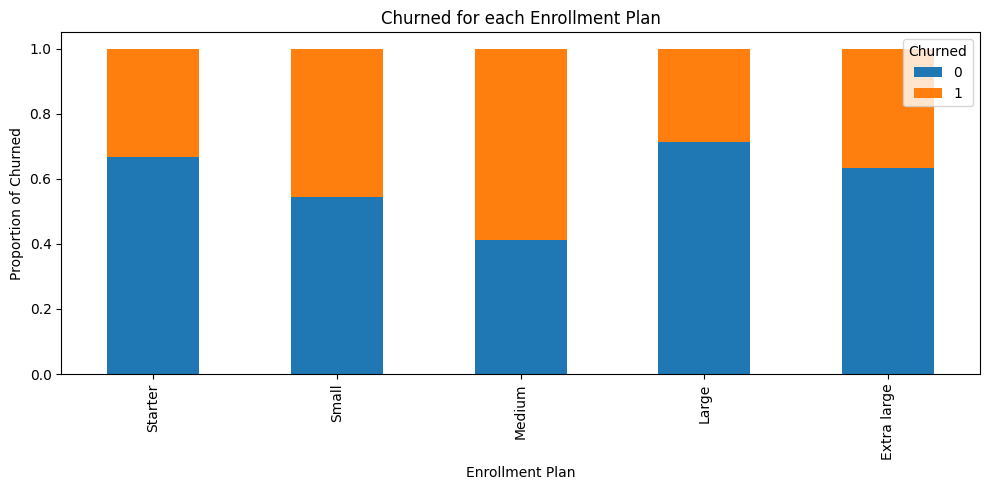

In [8]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Group by PromoType and Churned, count occurrences, and unstack for plotting
grouped = df[df['Churned'].notnull()].groupby(['Enrollment Plan', 'Churned']).size().unstack()

# Normalize the data to show proportions (optional)
grouped = grouped.div(grouped.sum(axis=1), axis=0)

# Plot the stacked bar chart
grouped.plot(kind='bar', stacked=True, ax=ax)

# Set title and labels
ax.set_title('Churned for each Enrollment Plan')
ax.set_ylabel('Proportion of Churned')  # Change to 'Count' if not normalizing
ax.set_xlabel('Enrollment Plan')

# Display the plot
plt.tight_layout()
plt.show()

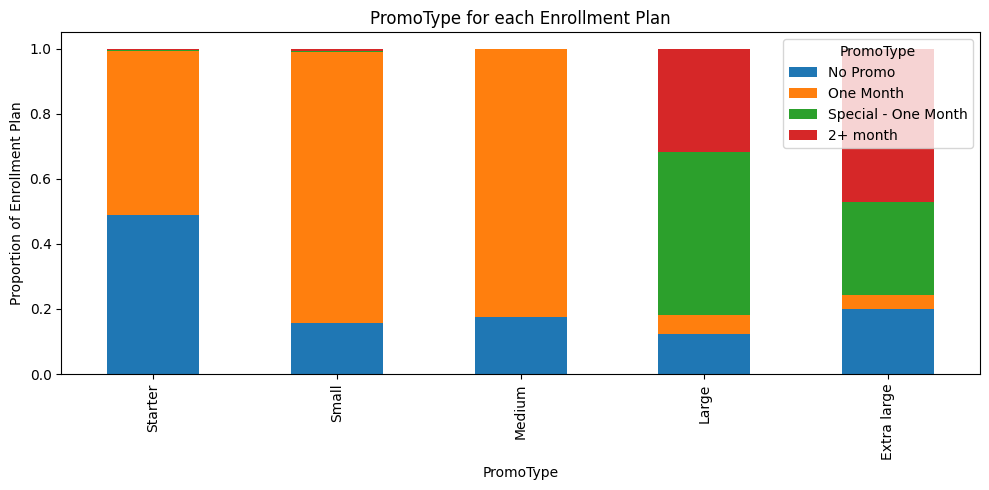

In [9]:
# Create the figure and axis ---------------------------
fig, ax = plt.subplots(figsize=(10, 5))

# Group by OrgSize and Enrollment Plan, count occurrences, and unstack for plotting 
grouped = df[df['PromoType'].notnull()].groupby(['Enrollment Plan', 'PromoType']).size().unstack()

# Normalize the data to show proportions (optional)
grouped = grouped.div(grouped.sum(axis=1), axis=0)

# Plot the stacked bar chart
grouped.plot(kind='bar', stacked=True, ax=ax)

# Set title and labels
ax.set_title('PromoType for each Enrollment Plan')
ax.set_ylabel('Proportion of Enrollment Plan')  # Change to 'Count' if not normalizing
ax.set_xlabel('PromoType')

# Display the plot
plt.tight_layout()
plt.show()

C:\Users\gfmar\AppData\Local\Temp\ipykernel_31972\1196986414.py:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


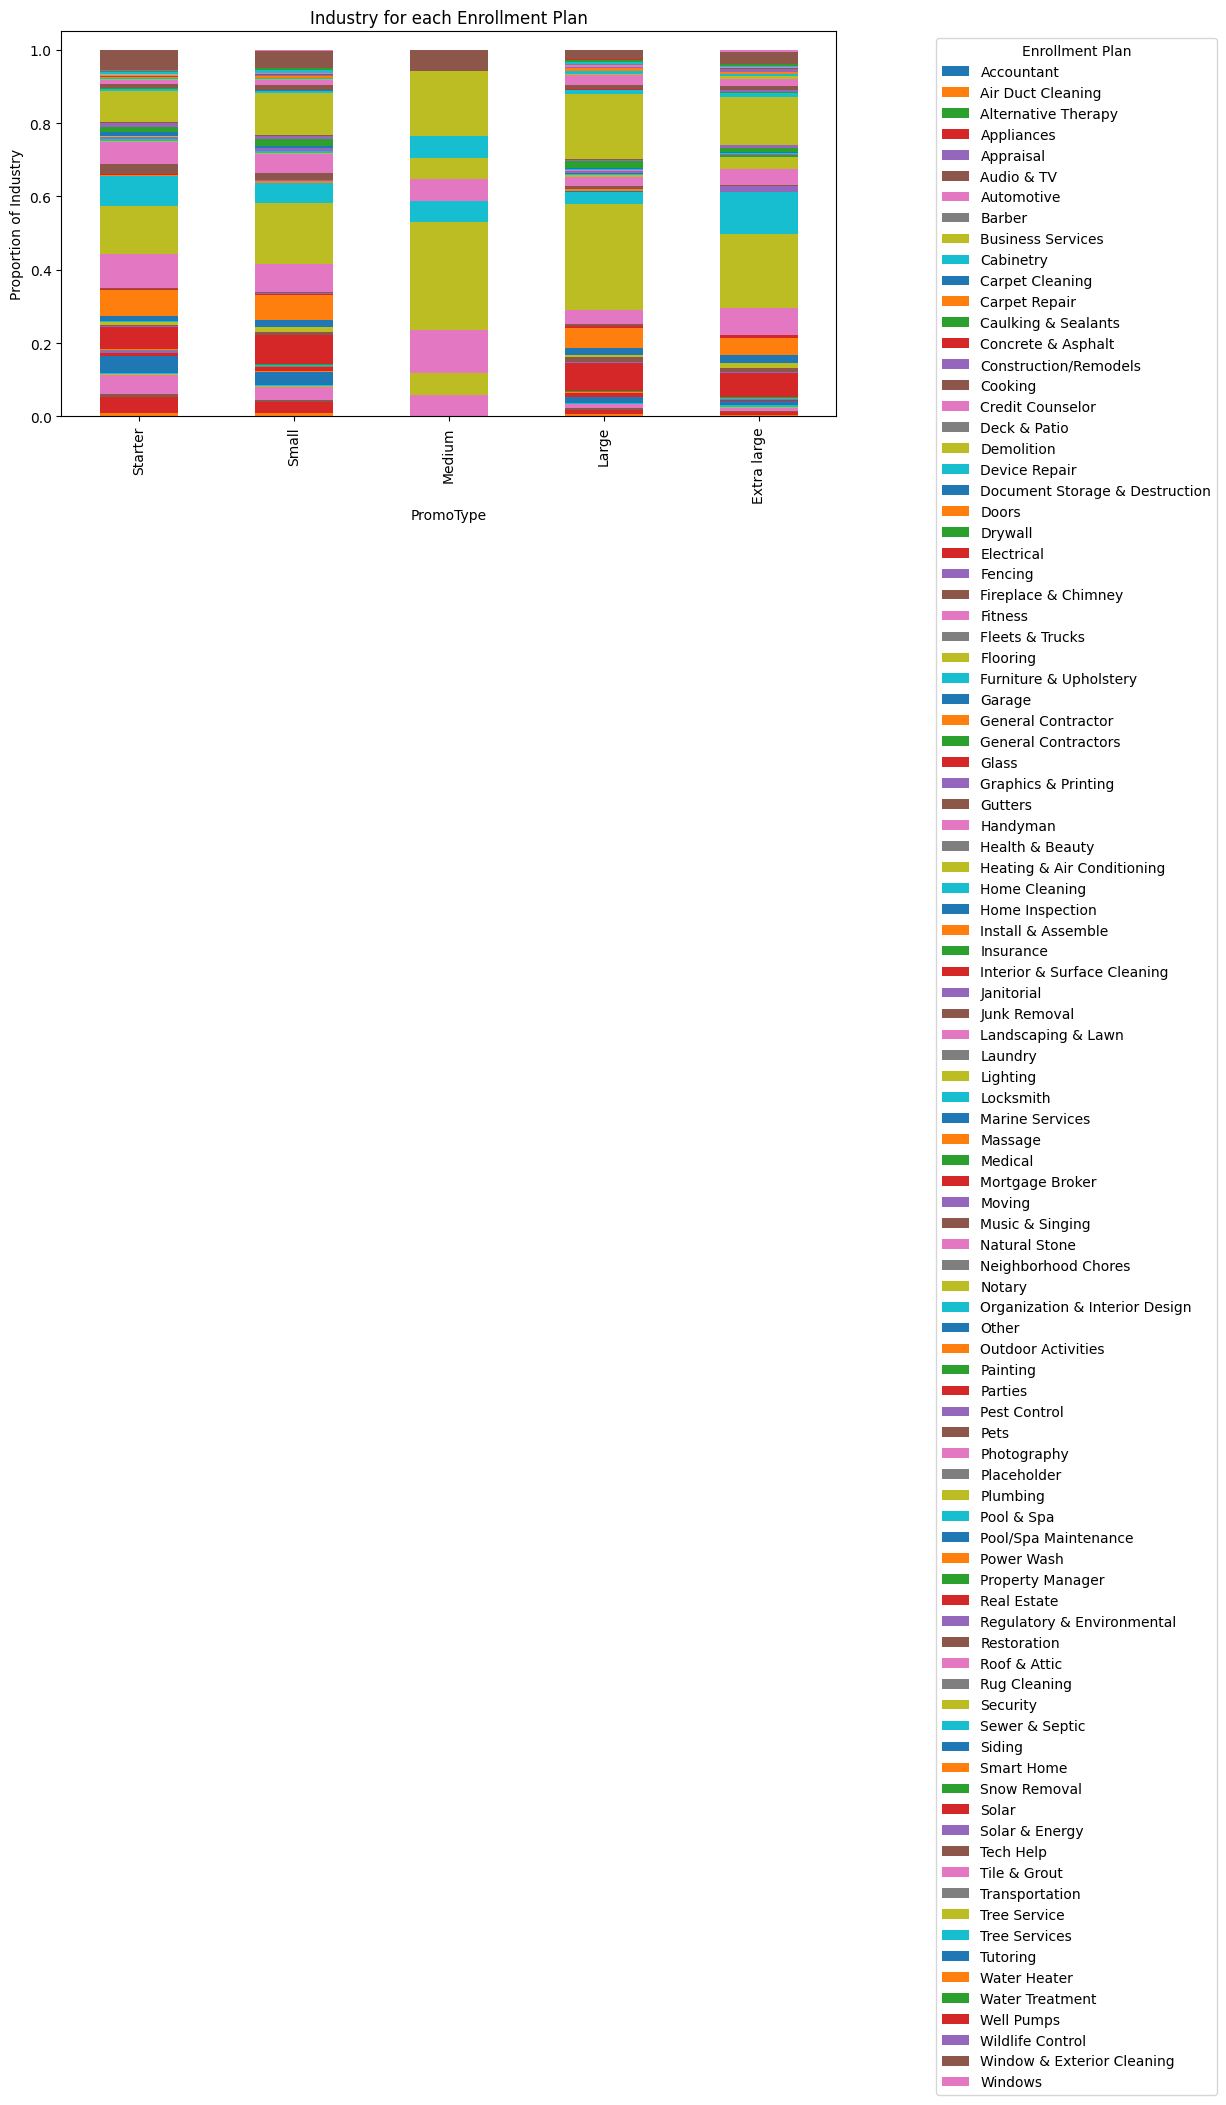

In [10]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Group by PromoType and OrgSize, count occurrences, and unstack for plotting
grouped = df[df['Industry'].notnull()].groupby(['Enrollment Plan', 'Industry']).size().unstack()

# Normalize the data to show proportions (optional)
grouped = grouped.div(grouped.sum(axis=1), axis=0)

# Plot the stacked bar chart
grouped.plot(kind='bar', stacked=True, ax=ax)

# Set title and labels
ax.set_title('Industry for each Enrollment Plan')
ax.set_ylabel('Proportion of Industry')  # Change to 'Count' if not normalizing
ax.set_xlabel('PromoType')

# Move the legend to a better location
ax.legend(title='Enrollment Plan', loc='upper right', bbox_to_anchor=(1.5, 1))

# Display the plot
plt.tight_layout()
plt.show()

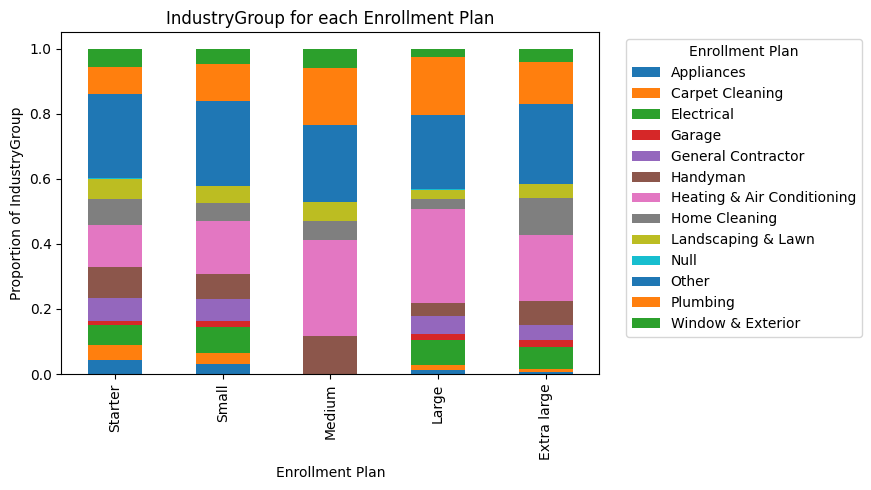

In [11]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Group by OrgSize and Enrollment Plan, count occurrences, and unstack for plotting
grouped = df[df['IndustryGroup'].notnull()].groupby(['Enrollment Plan', 'IndustryGroup']).size().unstack()

# Normalize the data to show proportions (optional)
grouped = grouped.div(grouped.sum(axis=1), axis=0)

# Plot the stacked bar chart
grouped.plot(kind='bar', stacked=True, ax=ax)

# Set title and labels
ax.set_title('IndustryGroup for each Enrollment Plan')
ax.set_ylabel('Proportion of IndustryGroup')  # Change to 'Count' if not normalizing
ax.set_xlabel('Enrollment Plan')

# Move the legend to a better location
ax.legend(title='Enrollment Plan', loc='upper right', bbox_to_anchor=(1.5, 1))

# Display the plot
plt.tight_layout()
plt.show()

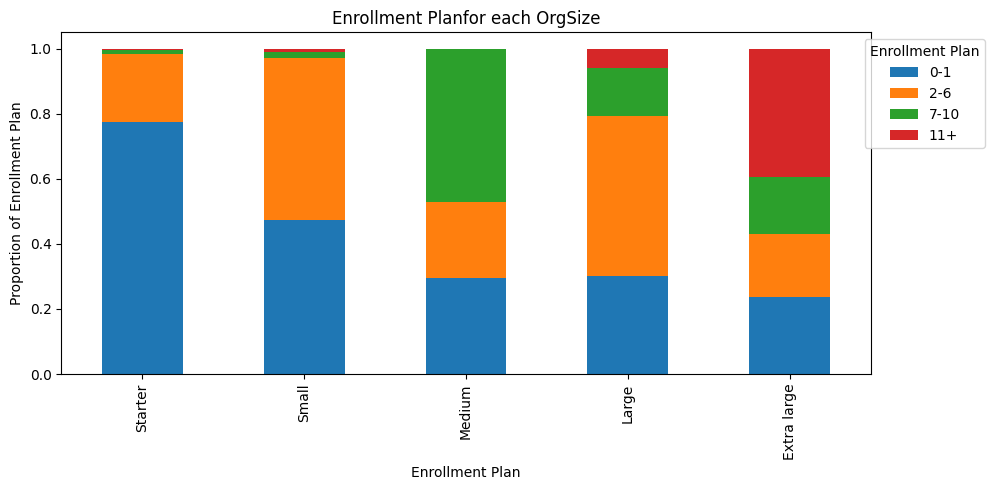

In [12]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Group by OrgSize and Enrollment Plan, count occurrences, and unstack for plotting
grouped = df[df['OrgSize'].notnull()].groupby(['Enrollment Plan', 'OrgSize']).size().unstack()

# Normalize the data to show proportions (optional)
grouped = grouped.div(grouped.sum(axis=1), axis=0)

# Plot the stacked bar chart
grouped.plot(kind='bar', stacked=True, ax=ax)

# Set title and labels
ax.set_title('Enrollment Planfor each OrgSize')
ax.set_ylabel('Proportion of Enrollment Plan')  # Change to 'Count' if not normalizing
ax.set_xlabel('Enrollment Plan')

# Move the legend to a better location
ax.legend(title='Enrollment Plan', loc='upper right', bbox_to_anchor=(1.15, 1))

# Display the plot
plt.tight_layout()
plt.show()

In [13]:
df_filtered = df[(df['OrgSize'] == '2-6') & (df['Enrollment Plan'].isin(['Small', 'Large']))] 

df_filtered_grouped = pd.DataFrame()    
df_filtered_grouped['Small_Users'] = df_filtered[df['Enrollment Plan'] == 'Small'].groupby('Industry')['Enrollment Plan'].count()  / len(df_filtered[df['Enrollment Plan'] == 'Small'])
df_filtered_grouped['Large_Users'] = df_filtered[df['Enrollment Plan'] == 'Large'].groupby('Industry')['Enrollment Plan'].count() / len(df_filtered[df['Enrollment Plan'] == 'Large'])
df_filtered_grouped['Difference'] = (df_filtered_grouped['Large_Users'] - df_filtered_grouped['Small_Users']) * 100

df_filtered_grouped.sort_values(by='Difference', ascending=False, inplace=True)
df_filtered_grouped.head(10)





C:\Users\gfmar\AppData\Local\Temp\ipykernel_31972\890961695.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered_grouped['Small_Users'] = df_filtered[df['Enrollment Plan'] == 'Small'].groupby('Industry')['Enrollment Plan'].count()  / len(df_filtered[df['Enrollment Plan'] == 'Small'])
C:\Users\gfmar\AppData\Local\Temp\ipykernel_31972\890961695.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered_grouped['Small_Users'] = df_filtered[df['Enrollment Plan'] == 'Small'].groupby('Industry')['Enrollment Plan'].count()  / len(df_filtered[df['Enrollment Plan'] == 'Small'])
C:\Users\gfmar\AppData\Local\Temp\ipykernel_31972\890961695.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered_grouped['Large_Users'] = df_filtered[df['Enrollment Plan'] == 'Large'].groupby('Industry')['Enrollment Plan'].count() / len(df_filtered[df['Enrollment Plan'] == 'Large'])
C:\Users\gfmar\Ap

,Small_Users,Large_Users,Difference
Industry,,,
Heating & Air Conditioning,0.151193,0.322358,17.116524
Plumbing,0.112492,0.178407,6.591487
Fireplace & Chimney,0.006617,0.018377,1.175952
Roof & Attic,0.017245,0.023737,0.649176
Sewer & Septic,0.006216,0.009188,0.297220
Lighting,0.002607,0.005360,0.275310
Real Estate,0.000401,0.002297,0.189605
Fencing,0.003810,0.005360,0.154997
Security,0.002406,0.003828,0.142223


C:\Users\gfmar\AppData\Local\Temp\ipykernel_31972\624098651.py:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


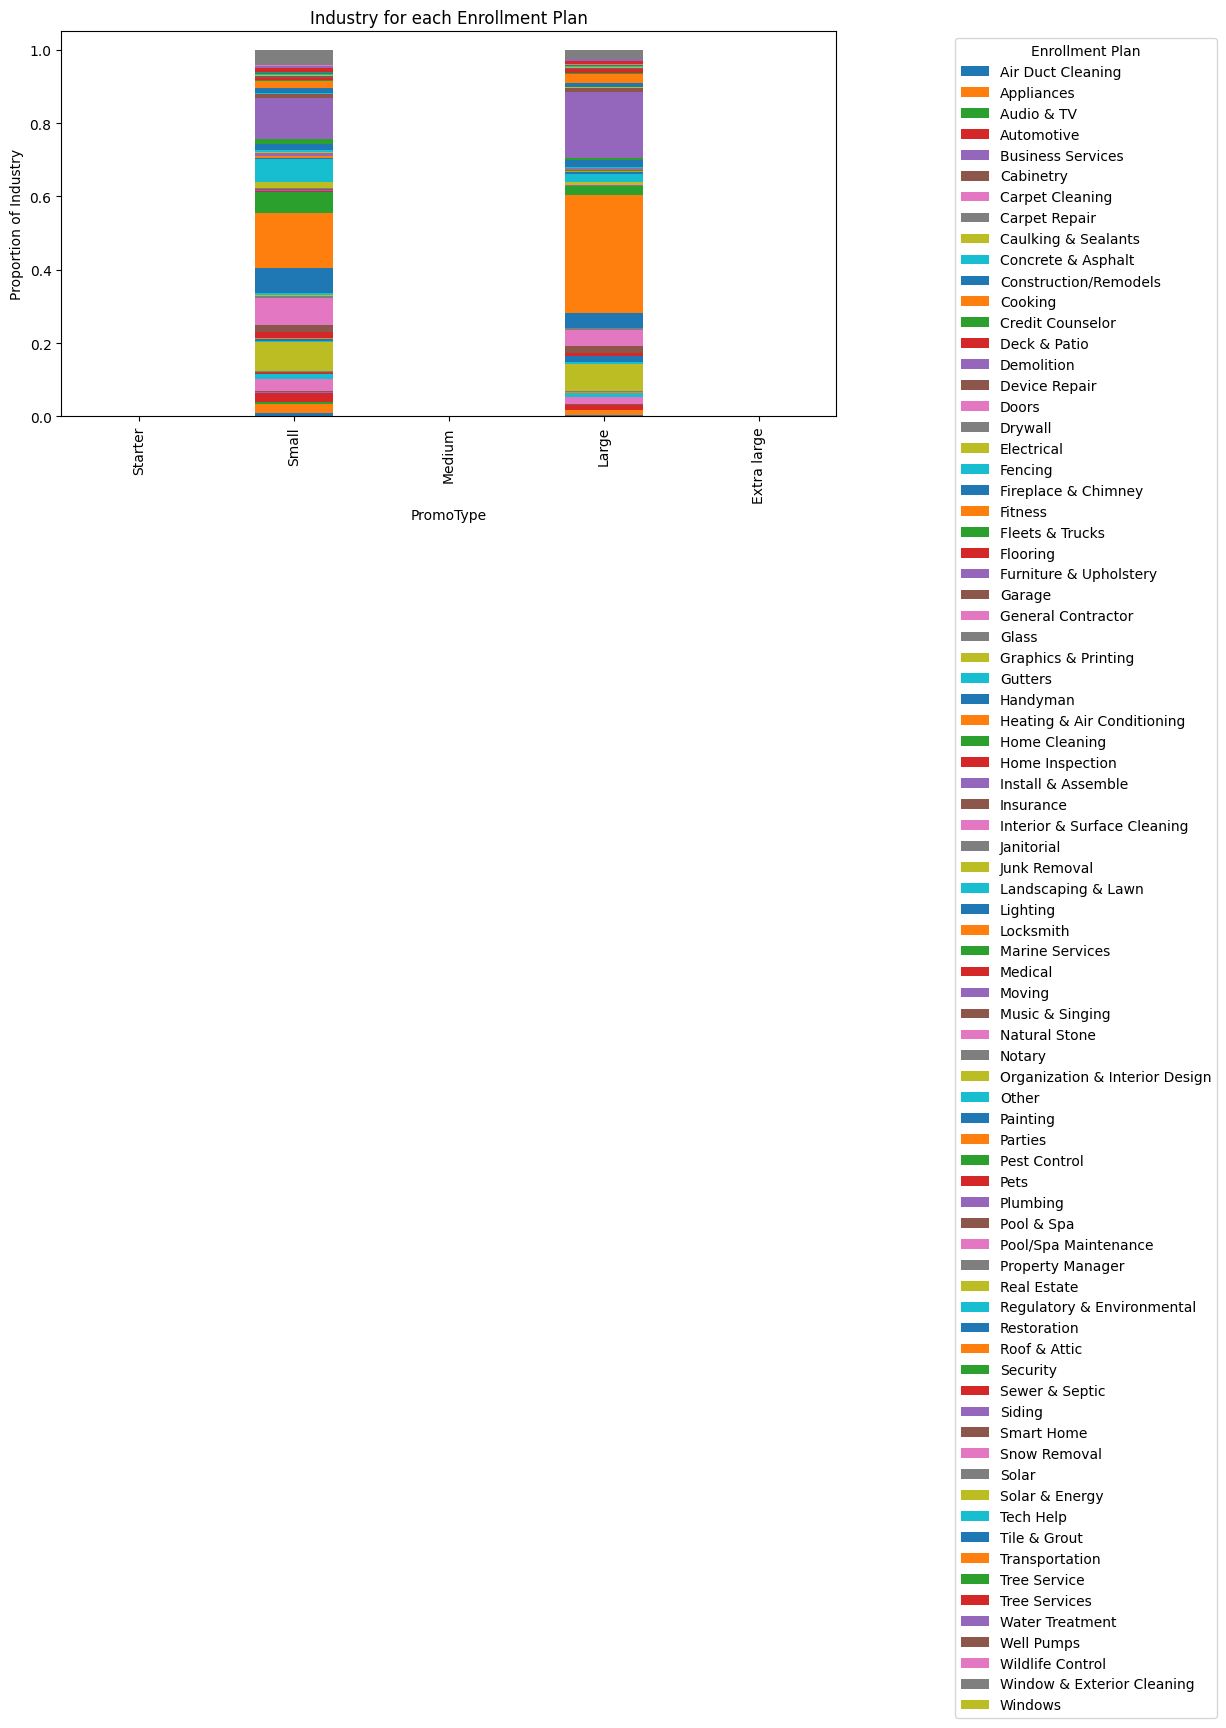

In [14]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Group by PromoType and OrgSize, count occurrences, and unstack for plotting
grouped = df_filtered[df_filtered['Industry'].notnull()].groupby(['Enrollment Plan', 'Industry']).size().unstack()

# Normalize the data to show proportions (optional)
grouped = grouped.div(grouped.sum(axis=1), axis=0)

# Plot the stacked bar chart
grouped.plot(kind='bar', stacked=True, ax=ax)

# Set title and labels
ax.set_title('Industry for each Enrollment Plan')
ax.set_ylabel('Proportion of Industry')  # Change to 'Count' if not normalizing
ax.set_xlabel('PromoType')

# Move the legend to a better location
ax.legend(title='Enrollment Plan', loc='upper right', bbox_to_anchor=(1.5, 1))

# Display the plot
plt.tight_layout()
plt.show()

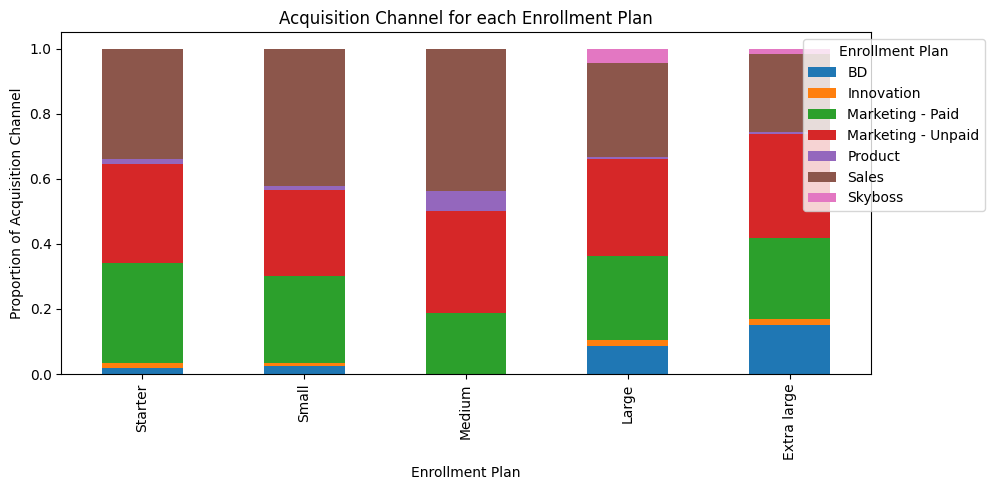

In [15]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Group by Enrollment Planand Enrollment Plan, count occurrences, and unstack for plotting
grouped = df[df['Acquisition Channel'].notnull()].groupby(['Enrollment Plan', 'Acquisition Channel']).size().unstack()

# Normalize the data to show proportions (optional)
grouped = grouped.div(grouped.sum(axis=1), axis=0)

# Plot the stacked bar chart
grouped.plot(kind='bar', stacked=True, ax=ax)

# Set title and labels
ax.set_title('Acquisition Channel for each Enrollment Plan')
ax.set_ylabel('Proportion of Acquisition Channel')  # Change to 'Count' if not normalizing
ax.set_xlabel('Enrollment Plan')

# Move the legend to a better location
ax.legend(title='Enrollment Plan', loc='upper right', bbox_to_anchor=(1.15, 1))

# Display the plot
plt.tight_layout()
plt.show()

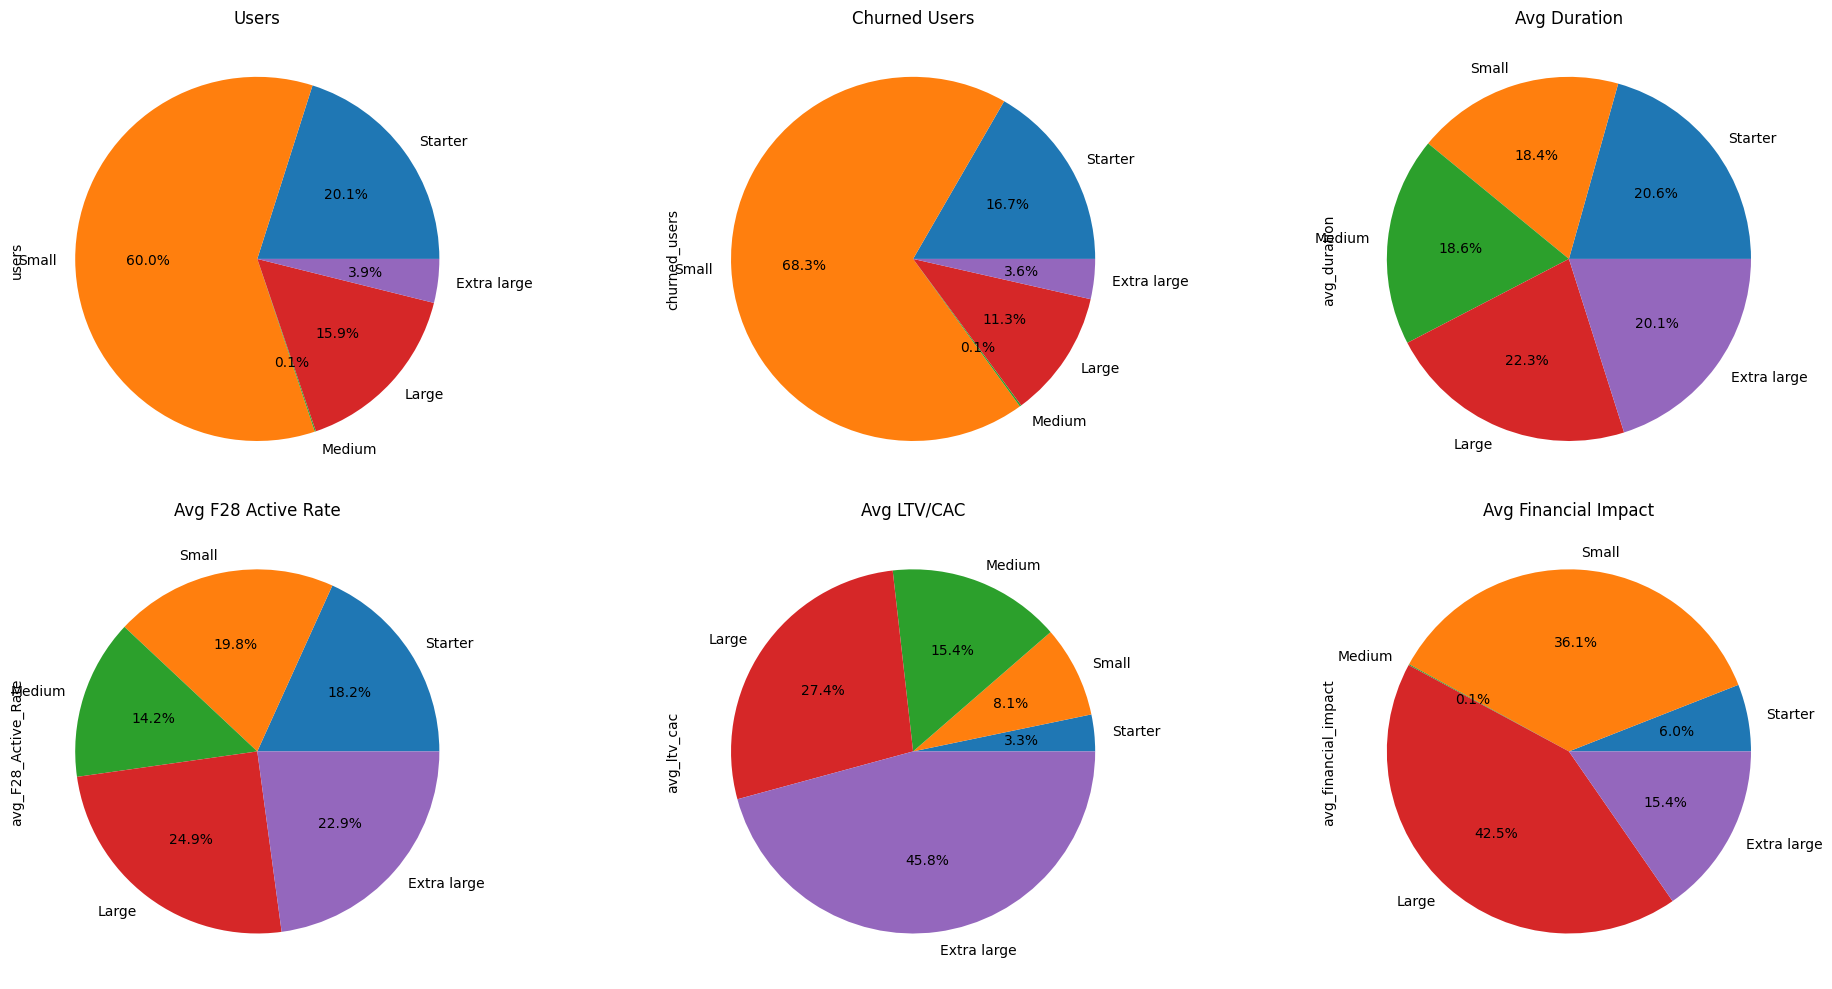

In [16]:
#subplot of the df_promo dataframe with 6 pie charts for: users, churned_users,avg_duration, 
# avg_F28_Active_Rate, avg_ltv_cac, avg_financial_impact
fig, axs = plt.subplots(2,3, figsize=(20, 10))
df_promo['users'].plot.pie(ax=axs[0,0], autopct='%1.1f%%')
axs[0,0].set_title('Users')

df_promo['churned_users'].plot.pie(ax=axs[0,1], autopct='%1.1f%%')
axs[0,1].set_title('Churned Users')

df_promo['avg_duration'].plot.pie(ax=axs[0,2], autopct='%1.1f%%')
axs[0,2].set_title('Avg Duration')

df_promo['avg_F28_Active_Rate'].plot.pie(ax=axs[1,0], autopct='%1.1f%%')
axs[1,0].set_title('Avg F28 Active Rate')

df_promo['avg_ltv_cac'].plot.pie(ax=axs[1,1], autopct='%1.1f%%')
axs[1,1].set_title('Avg LTV/CAC')

df_promo['avg_financial_impact'].plot.pie(ax=axs[1,2], autopct='%1.1f%%')
axs[1,2].set_title('Avg Financial Impact')

plt.tight_layout()
plt.show()
